In [1]:
import math
from typing import Tuple
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import torch.optim as optim
import time
import numpy as np
from tqdm import tqdm as tqdm

In [2]:
# fix file path in google colab
from google.colab import drive
drive.mount('/content/drive')

# change path
import os
os.chdir('/content/drive/MyDrive/Lab8')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip install torch==2.0.1 torchtext==0.15.2
# !pip install torchtext
!pip install portalocker


  Using cached torch-2.0.1-cp310-cp310-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached torchtext-0.15.2-cp310-cp310-manylinux1_x86_64.whl.metadata (7.4 kB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_cupti_cu11-11.7.101-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cufft_cu11-10.9.0.58-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu11-10.2.10.91-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu11-11.4.0.1-2-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu11-11.7.4.91-py3-none-manylinux1_x86_64.whl

In [7]:
# !pip show torch torchtext
# !pip uninstall torch torchtext -y

Name: torch
Version: 2.5.1+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchtext, torchvision
---
Name: torchtext
Version: 0.18.0
Summary: Text utilities, models, transforms, and datasets for PyTorch.
Home-page: https://github.com/pytorch/text
Author: PyTorch Text Team
Author-email: packages@pytorch.org
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, requests, torch, tqdm
Required-by: 
Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchtext 0.18.0
Uninstalling torchtext-0.18.0:
  Successfully uninst

In [3]:
import torchtext
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch
from torch.utils.data import DataLoader
from collections import Counter


# Load dataset and initialize tokenizer
train_iter, test_iter = AG_NEWS(root='datasets', split=('train', 'test'))

label_counts = Counter()
for label, samples in train_iter:
    label_counts[label] += 1
print("Label distribution in train_iter:", label_counts)

label_counts = Counter()
for label, _ in test_iter:
    label_counts[label] += 1
print("Label distribution in test_iter:", label_counts)

Label distribution in train_iter: Counter({3: 30000, 4: 30000, 2: 30000, 1: 30000})
Label distribution in test_iter: Counter({3: 1900, 4: 1900, 2: 1900, 1: 1900})


In [4]:
import torch
torch.cuda.empty_cache()

In [5]:
# Reload train_iter for use in DataLoader
train_iter, test_iter = AG_NEWS(root='datasets', split=('train', 'test'))
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Create vocabulary with special tokens for padding and unknown words
# vocab = # your code here
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

In [6]:
def text_pipeline(x):
    return vocab(tokenizer(x))

# Example: Test the pipeline on a sample text
sample_text = "This movie was fantastic!"
print(text_pipeline(sample_text))

[53, 1348, 36, 9193, 765]


120000it [00:06, 19542.63it/s]
7600it [00:00, 26172.11it/s]


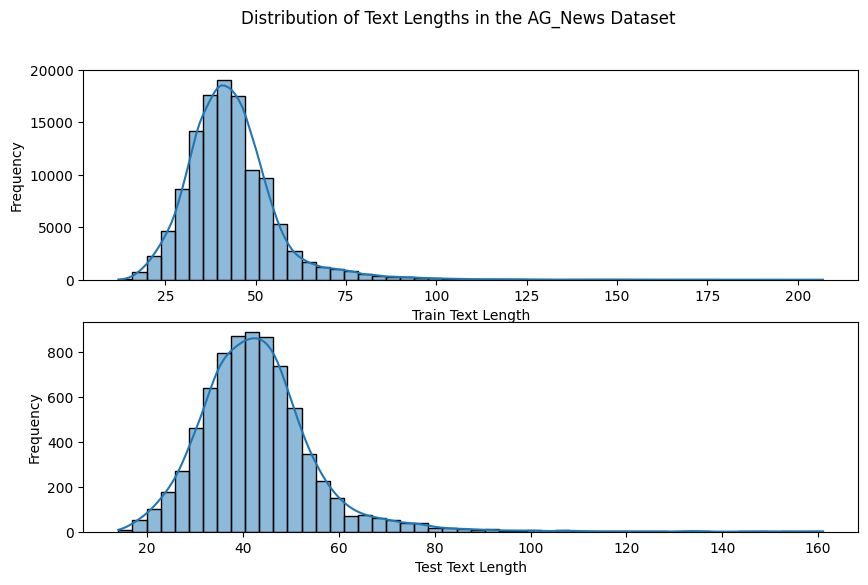

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Plot the length distribution of training and testing datasets
# Your code here


# import matplotlib.pyplot as plt
# import seaborn as sns

# Function to calculate the length of each text in the dataset
def get_text_lengths(data_iter):
    lengths = []
    for _, text in tqdm(data_iter):
        tokenized_text = tokenizer(text)
        lengths.append(len(tokenized_text))
    return np.array(lengths)

# Load AG_NEWS train dataset
train_iter, test_iter = AG_NEWS(root='datasets', split=('train', 'test'))

# Get text lengths from the entire dataset
train_text_lengths = get_text_lengths(train_iter)
test_text_lengths = get_text_lengths(test_iter)
# Plot the distribution of text lengths

# Define bin edges using the range of both datasets
min_bin = min(train_text_lengths.min(), test_text_lengths.min())
max_bin = max(train_text_lengths.max(), test_text_lengths.max())
bins = np.linspace(min_bin, max_bin, 30)  # Adjust number of bins as needed

plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
sns.histplot(train_text_lengths, kde=True, bins=50)
plt.xlabel('Train Text Length')
plt.ylabel('Frequency')
plt.subplot(2,1,2)
sns.histplot(test_text_lengths, kde=True, bins=50)
plt.xlabel('Test Text Length')
plt.ylabel('Frequency')
plt.suptitle('Distribution of Text Lengths in the AG_News Dataset')
plt.show()

In [8]:
from torch.nn.utils.rnn import pad_sequence

# Define collate function for padding and batching
# setting a max_seq_len helps with estimating the max gpu memory usage
def collate_batch(batch, max_seq_len=1024):
    labels, texts = zip(*batch)
    # the labels start at 1 but predictions start at 0. To align them, we modify lables
    labels = torch.tensor(labels,dtype=torch.long)-1

    text_list = []
    for text in texts:
        # Truncate or pad to max_seq_len
        tokenized_text = text_pipeline(text)
        if len(tokenized_text) > max_seq_len:
            tokenized_text = tokenized_text[:max_seq_len]  # Truncate if longer than max_seq_len
        else:
            # Pad if shorter than max_seq_len
            tokenized_text = tokenized_text + [vocab["<pad>"]] * (max_seq_len - len(tokenized_text))

        text_list.append(torch.tensor(tokenized_text, dtype=torch.long))

    padded_texts = torch.stack(text_list)  # Stack the sequences into a tensor
    return padded_texts, labels

In [9]:
from torch.utils.data import Dataset
class AG_NEWS_Dataset(Dataset):
    def __init__(self, data_iter):
        self.data_iter = list(data_iter)  # Converting the iterator to a list for easier access

    def __len__(self):
        return len(self.data_iter)

    def __getitem__(self, idx):
        label, text = self.data_iter[idx]
        return label, text

train_iter, test_iter = AG_NEWS(root='datasets', split=('train', 'test'))
train_dataset = AG_NEWS_Dataset(train_iter)
test_dataset = AG_NEWS_Dataset(test_iter)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [10]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, num_encoder_layers, num_classes, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embed_size, num_heads, embed_size * 2, dropout),
            num_encoder_layers
        )
        self.fc = nn.Linear(embed_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)  # Embedding layer
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, embedding_size)
        x = self.transformer(x)  # Apply transformer
        x = x.mean(dim=0)  # Pooling (take the mean of all tokens in the sequence)
        x = self.dropout(x)
        x = self.fc(x)  # Final classification layer
        return x

In [11]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [12]:
# Check for device compatibility, prioritizing CUDA, then MPS for MacBooks with Apple Silicon, and defaulting to CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")



# Initialize the model,
embed_size = 32
num_heads = 4
num_encoder_layers = 2
num_classes = 4
model = TransformerModel(len(vocab), embed_size, num_heads, num_encoder_layers, num_classes)

# Initialize loss function, and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



# device = "cpu"
print(f"Using device: {device}")
model.to(device)


Using device: cuda
Using device: cuda


TransformerModel(
  (embedding): Embedding(95812, 32)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=32, out_features=4, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [13]:
import torch
torch.cuda.empty_cache()

In [14]:
def train_epoch(model, train_loader, loss_fn, optimizer):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    # total_batches = 0
    total_batches = len(train_loader)

    for texts, labels in tqdm(train_loader):
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(texts)

        # Compute loss and gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Calculate accuracy
        preds = torch.argmax(outputs, dim=1)
        correct = (preds == labels).sum().item()
        accuracy = correct / labels.size(0)

        epoch_loss += loss.item()
        epoch_accuracy += accuracy

    return epoch_loss / total_batches, epoch_accuracy / total_batches


def evaluate(model, test_loader, loss_fn):
    model.eval()
    epoch_loss = 0
    epoch_accuracy = 0
    total_batches = len(test_loader)

    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            texts, labels = texts.to(device), labels.to(device)
            # Forward pass
            outputs = model(texts)

            # Compute loss
            loss = loss_fn(outputs, labels)

            # Calculate accuracy
            preds = torch.argmax(outputs, dim=1)
            correct = (preds == labels).sum().item()
            accuracy = correct / labels.size(0)

            epoch_loss += loss.item()
            epoch_accuracy += accuracy

    return epoch_loss / total_batches, epoch_accuracy / total_batches



In [15]:
num_epochs = 5
train_losses = np.zeros(num_epochs)
train_accuracies = np.zeros(num_epochs)

test_losses = np.zeros(num_epochs)
test_accuracies = np.zeros(num_epochs)

In [16]:
for epoch in range(num_epochs):
    start_time = time.time()

    # Train for one epoch
    train_loss, train_accuracy = train_epoch(model, train_loader, loss_fn, optimizer)
    train_losses[epoch] = train_loss
    train_accuracies[epoch] = train_accuracy
    # Evaluate on the test set
    test_loss, test_accuracy = evaluate(model, test_loader, loss_fn)
    test_losses[epoch] = test_loss
    test_accuracies[epoch] = test_accuracy
    end_time = time.time()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Time: {end_time - start_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

100%|██████████| 238/238 [00:05<00:00, 44.37it/s]


Epoch [1/5] | Time: 478.85s
Train Loss: 0.5302 | Train Accuracy: 0.7978
Test Loss: 0.3576 | Test Accuracy: 0.8782


100%|██████████| 238/238 [00:05<00:00, 46.34it/s]


Epoch [2/5] | Time: 478.80s
Train Loss: 0.2912 | Train Accuracy: 0.9007
Test Loss: 0.2970 | Test Accuracy: 0.8996


100%|██████████| 238/238 [00:05<00:00, 44.23it/s]


Epoch [3/5] | Time: 476.01s
Train Loss: 0.2340 | Train Accuracy: 0.9213
Test Loss: 0.2832 | Test Accuracy: 0.9055


100%|██████████| 238/238 [00:05<00:00, 42.81it/s]


Epoch [4/5] | Time: 475.69s
Train Loss: 0.1953 | Train Accuracy: 0.9344
Test Loss: 0.2916 | Test Accuracy: 0.9074


100%|██████████| 238/238 [00:05<00:00, 44.86it/s]

Epoch [5/5] | Time: 472.64s
Train Loss: 0.1656 | Train Accuracy: 0.9447
Test Loss: 0.2893 | Test Accuracy: 0.9081


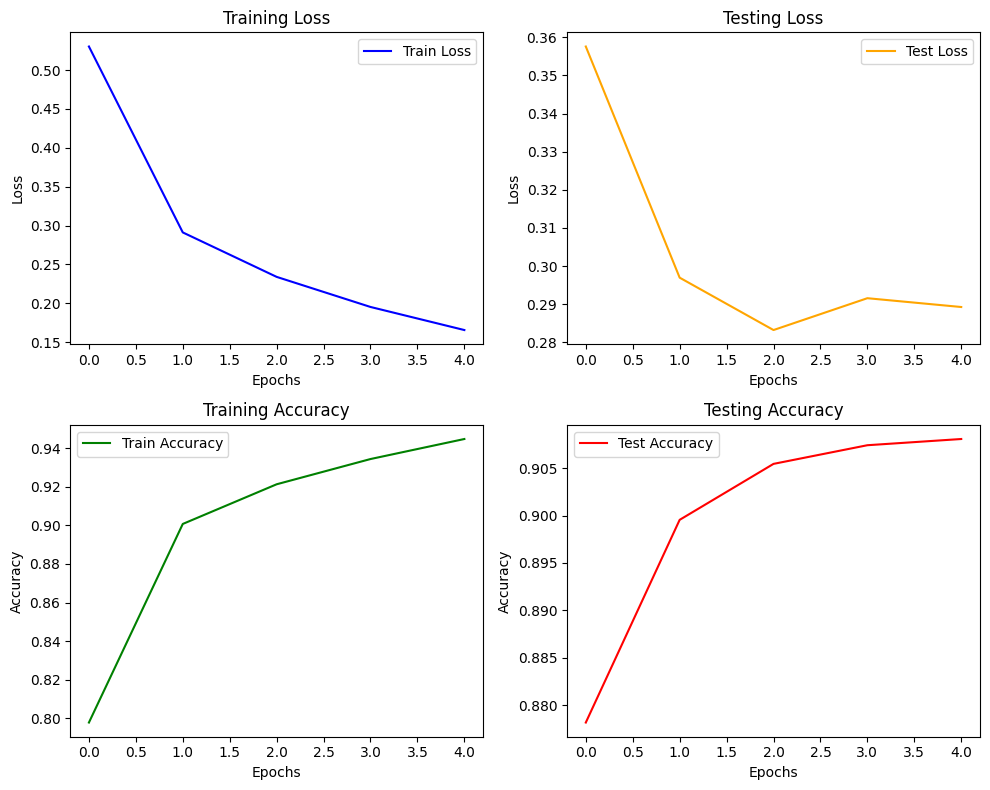

In [17]:
num_epochs = 5
epochs = list(range(0, num_epochs))

# Create 2x2 grid of subplots using plt.subplot
plt.figure(figsize=(10, 8))

# Training Loss
plt.subplot(2, 2, 1)  # (rows, columns, index)
plt.plot(epochs, train_losses, color='blue', label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Testing Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, test_losses, color='orange', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, train_accuracies, color='green', label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Testing Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, test_accuracies, color='red', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()